In [1]:
import numpy as np

import networkx as nx
from random import random
from numpy import arctan2, pi

import scipy.stats as sts
from scipy.stats import norm
from scipy import signal

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from PIL import Image, ImageDraw, ImageFont

# Problem 1: Rainfall Records

According to [Ru Geld](https://ru-geld.de/en/country/weather-and-climate/precipitation.html#by-states), Berlin received 511.12 mm of rainfall in 2020. Historical records stretching further back for the city were hard to come by, but a timeseries plot of annual rainfall in Germany between 2011 and 2020 suggested a random walk-like behavior: roughly even number of steps up and down, and asymmetrical pattern of step sizes (largely the same, but with few very large/very small exceptions). 

As a result, we will assume that rainfall is normally distributed with mean 511, and standard deviation matched with the standard deviation of rainfall in Germany between 2011 and 2020. This assumes that the variation in weather in the city of Berlin will approximately follow the variation in weather in the country as a whole, albeit with a mean nudged to the 2020 recorded value.

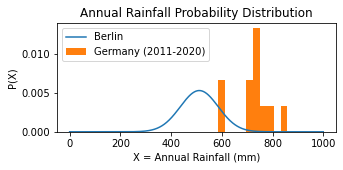

In [2]:
# Centererd on 511.1, rainfall in 2020
berlin_2020 = 511.12

# 2011 - 2020
annual_germany = [
    732.9, 767.5, 778.7, 727.1,
    701.3, 733.3, 858.7, 586.3,
    586.3, 735, 704.9]

variation  = np.std(annual_germany)

x = np.linspace(0,1000, 1000)
berlin_rainfall = sts.norm(berlin_2020, variation)

plt.figure(figsize = (5,2))
plt.plot(x, berlin_rainfall.pdf(x), label = "Berlin")
plt.hist(annual_germany, density=True, label = "Germany (2011-2020)")
plt.xlabel("X = Annual Rainfall (mm)")
plt.ylabel("P(X)")
plt.title("Annual Rainfall Probability Distribution")
plt.legend()
plt.show()


Content with the approximation, we can now simulate a century of rain by draing samples from this probability density function,

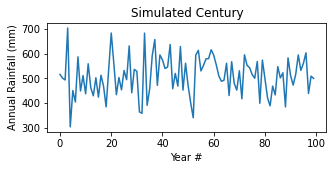

In [3]:
def sim_century(n = 101):
    """
    Simulates annual rainfall over n years. 

        Parameters: 
            n (int): Years to simulate
        
        Returns:
            record_years (int) : Number of record years observed (high and low)
            recorded_rain (arr): Rainfall for each year, for plotting
            first_record (int) : Year of first high/low record
    """

    recorded_rain = np.zeros(n - 1)

    first_year = berlin_rainfall.rvs()
    recorded_rain[0] = first_year

    record_high = first_year
    record_low = first_year

    record_years = 0
    first_record = 0

    for i in range (n - 1):
        # Simulate rain in current year
        this_year =  berlin_rainfall.rvs()
        recorded_rain[i] = this_year

        # Check is this is a record year
        if this_year > record_high:
            record_high = this_year
            record_years += 1
            if not first_record:
                first_record = i + 1

        if this_year < record_low:
            record_low = this_year
            record_years += 1 
    
    return record_years, first_record, recorded_rain

plt.figure(figsize = (5,2))
plt.plot(sim_century()[2])
plt.ylabel("Annual Rainfall (mm)")
plt.xlabel("Year #")
plt.title("Simulated Century")
plt.show()


2. Next, simulate the annual rainfall in Berlin for 101 consecutive years (labeled Year 0 up to Year 100) by generating i.i.d. samples from your chosen probability distribution. A rainfall value is a record high if it is greater than those in all previous years (starting with Year 0), and a record low if it is lower than those in all previous years. In the century starting from Year 1 and ending with Year 100 (including those two years), produce a histogram to show the distribution over the number of “record” years – i.e., the number of
years that have either a record high or a record low. Show empirically that the expected value of this distribution is,

$$ 2 \sum_{i = 1}^{100} \frac{1}{i + 1} $$

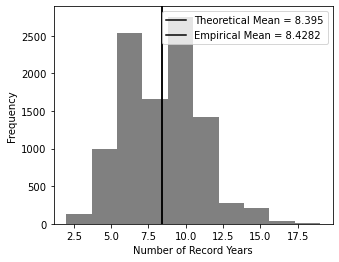

In [4]:
# MC simulation 
def mc_records(iter = 10000):
    """Simulate iter (int) centuries and return number of record years (list)"""
    records = []
    firsts  = []

    for i in range(iter):
        record, first, years = sim_century()
        records.append(record)
        firsts.append(first)

    return records, firsts

sim_records, sim_firsts = mc_records()

# Plot Results
plt.figure(figsize = (5,4))
i = np.arange(1,101)

# Compute theoretical expected value
theoretical_avg_record = round(2*sum(1/(i+1)),3)

plt.axvline(
    theoretical_avg_record,
    label = f'Theoretical Mean = { theoretical_avg_record}',
    color = 'black')
plt.axvline(
    np.mean(sim_records),
    label = f'Empirical Mean = {np.mean(sim_records)}',
    color = 'black'
)
plt.hist(
    sim_records,
    color = 'grey')
plt.ylabel("Frequency")
plt.xlabel("Number of Record Years")
plt.legend()
plt.show()

The theoretical and empirical expected values are identical to at least 3 decimal places. 


3. Next, use your rainfall distribution to simulate the first year after Year 0 when a record high (not low) rainfall occurs. Produce a histogram of the distribution over the number of years until the first record high after Year 0.
Show empirically, using a line plot on top of your histogram, that this distribution has probability mass function

$$ P(k) = \frac{1}{k(k + 1)} $$

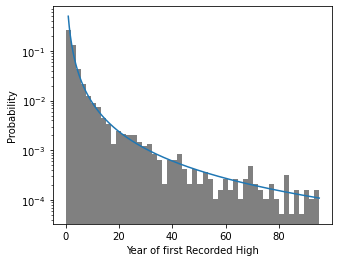

In [5]:
# Plot First Record
plt.figure(figsize = (5,4))
i = np.arange(1,101)
# Compute theoretical expected value
def theoretical_first(k): return 1/(k*(k+1))

cts, bins, _ =  plt.hist(
    sim_firsts,
    color = 'grey', 
    density=True, 
    bins = 50)

x = np.linspace(1 , max(bins), 1000)
plt.semilogy(x, theoretical_first(x))
plt.xlabel("Year of first Recorded High")
plt.ylabel("Probability")
plt.show()

After normalizing the histogram and overlaying the pmf, we see a close alignment between the theoretical and empirical distributions, even on a semi-log scale. There is some deviation towards later decades, though this might be because of undersampling and improper binning. 

4. Explain why your results in Questions 2 and 3 do not depend on your choice of rainfall distribution in Question 1.

In both cases, we are taking uncorrelated and independent draws from the same (continuous) distribution with a sample statistic ("Total Record Years" or "First Record High"), which is one way of 'ordering' these unordered sample draws. So as long as we can order them, the results do not vary with the distribution.

# Problem 2: Metropolis-Hastings

+ Implement the Metropolis-Hastings algorithm.
+ Explain what your proposal distribution is and why you chose it.
+ Explain the output from the algorithm, including how long it takes to reach equilibrium and how many steps you take between samples (and why).

In this problem, we attempt to draw samples from an unnormalized posterior distributed according to the following function,

In [6]:
def unnormalized_distribution(x, y):
    
    measurements = [2.349080, -1.276010, -2.081865]
    buoys = [[-2.5, 2], [2, -5], [-3, -4]]
    sigma = 10/180*pi
    posterior = 1
    for i in range(3):
        bearing = arctan2(buoys[i][1] - y, buoys[i][0] - x)
        difference = (bearing - measurements[i] + pi) % (2 * pi) - pi
        posterior *= norm.pdf(difference, loc=0, scale=sigma)
    return posterior

To take iid samples from the posterior, we will use a Metropolis-Hastings sampler `custom_mh`. Each iteration in `n` total iterations, it draws a sample from a bivariate normal proposal distribution, comprising an `x`  and `y` parameter draw. The x-normal has a scale parameter `eps_x` of 1, while the y-normal has a scale parameter `eps_y` of 2. These were set because of the oblong contours of the posterior distribution, where there is more variation along y than x. A larger `eps_y` will allow the sampler to cover the space of the distribution more easily, if at the cost of a lower acceptance rate (and in turn, convergence time). Overall, a bivariate normal was chosen because of how easy it was to encode priors about the shape and form of the posterior into its 2 parameters. 

To account for the early drift from initialization (1,1) to the posterior, we discard the first 10 samples (a `burn_in` period). Additionally, samples were taken every `step` iterations, to decorrelate samples as much as possible and place some guarantees on the samples being iid, 

In [7]:
def custom_mh(n = 100000, step = 20, burn_in = 10):
    """
    Performs Metropolis-Hastings sampling over a poserior
    """
    samples = np.zeros((2,n//step), dtype = np.float16)
    rejections = np.zeros(n)

    # Random Initializations, which will be discarded
    curr_x = np.random.randint(-2,2)
    curr_y = np.random.randint(-2,2)

    eps_x = 1
    eps_y = 2

    for i in range(n):
        proposal_x = norm(curr_x, eps_x).rvs()
        proposal_y = norm(curr_y, eps_y).rvs()

        proposal = unnormalized_distribution(proposal_x,proposal_y)
        current = unnormalized_distribution(curr_x, curr_y)
        ratio = proposal/current

        accept = random() < min(1,ratio)

        if accept:
            curr_x = proposal_x
            curr_y = proposal_y
        else:
            rejections[i] = 1
        
        if i % step == 0 and i > burn_in:
            samples[:, i//step] = curr_x, curr_y

    return samples

samples = custom_mh()

chain1,chain2,chain3 = custom_mh(100000), custom_mh(100000), custom_mh(100000)

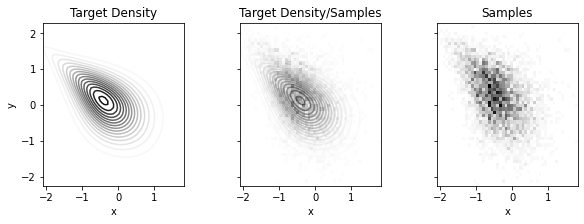

In [8]:
fig, axs = plt.subplots(1,3, figsize = (10,3), sharey=True)

Z, x, y = np.histogram2d(
    samples[1,:], 
    samples[0,:], 
    bins = [50,50])
xx,yy = np.meshgrid(x,y)
c = unnormalized_distribution(xx,yy)

for ax, alpha, title in zip(axs.flatten(), [1,0.5,0], ["Target Density", "Target Density/Samples", "Samples"]):
    ax.imshow(
        Z, 
        interpolation= 'nearest',
        alpha = 1 - alpha,
        origin= 'lower',
        extent=[x[0], x[-1], y[0], y[-1]], 
        cmap = "Greys")

    ax.contour(
        xx, yy, c,
        15,
        alpha = alpha,
        cmap = 'Greys'
    )
    ax.set_xlabel("x")
    if alpha == 1:
        ax.set_ylabel("y")
    ax.set_title(title)

plt.show()

From the plot above, we can see that the MH sampler seems to have approximated the comet-like shape of the posterior (Target Density, Left), given by a tight overlap of the Target Density/Samples (Center). In Samples (right), we can see that the tall posterior mode at ~(-0.2,0) was also approximated well, with darker patches corresponding to that region. For more granular detail, the following plot was produced,

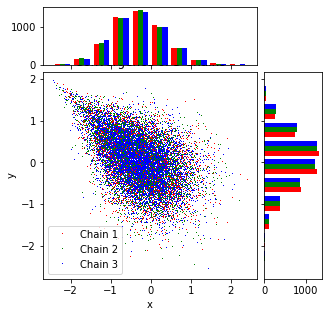

In [9]:
fig, ax = plt.subplots(figsize=(5, 5), sharex = False)

# the scatter plot:
ax.plot(
    chain1[0,:],
    chain1[1,:], 
    ',',
    alpha = 1,
    c = 'red',
    label = 'Chain 1')

ax.plot(
    chain2[0,:],
    chain2[1,:], 
    ',',
    alpha = 1,
    c = 'green',
    label = 'Chain 2')

ax.plot(
    chain3[0,:],
    chain3[1,:], 
    ',',
    alpha = 1,
    c = 'blue',
    label = 'Chain 3')


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

ax_histx.hist([chain1[0,:], chain2[0,:], chain3[0,:]], bins=10, color = ['red','green','blue'])
ax_histy.hist([chain1[1,:],chain2[1,:],chain2[1,:]], bins=10, orientation='horizontal', color = ['red','green','blue'])

ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Convergence of 3 Chains")
ax.legend()

# Plot autocorrelation
plt.show()

Run with 3 separate chains, we still converge over a similar distribution over x and y posterior parameters. This implies that the parameter space is well-explored. The last check we need to perform is on autocorrelation,

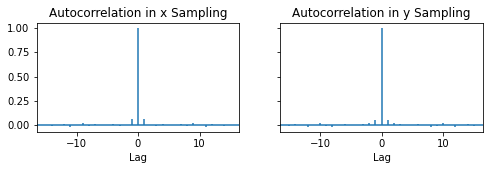

In [10]:
fig, ax = plt.subplots(1,2, figsize=(8, 2), sharey = True)

for i,p in zip(range(2), ['x', 'y']):
    ax[i].acorr(
        samples[i,:], 
        maxlags=15, 
        detrend=lambda x: signal.detrend(x, type='linear'))
    ax[i].set_xlabel("Lag")
    ax[i].set_title(f"Autocorrelation in {p} Sampling")

plt.show()

In an autocorrelation plot, we guage how well a series predicts a lagged version of itself, or, if there is a **dependence** between the next set of points, given the current set. 

Both plots indicate very low autocorrelation  (the perfect correlation at Lag = 0 just implies that there is a series is perfectly correlated with itself, so it can be ignored), which loosely promises independence between samples. 

# Problem 3: Diameter and Average Distance

1. Provide an example of a graph with at least 6 nodes where the diameter is equal to the
average distance. Explain why the metrics are equal.

In [11]:
def get_shortest_paths(g):
    """ Return the shortest paths in g from each node to any other node."""
    a = nx.shortest_path(g)
    shortest_paths = []

    for target in a.values():
        for path in target.values():
            # exclude self to self paths
            shortest_path = len(path) - 1
            if shortest_path > 0:
                shortest_paths.append(len(path) - 1)

    return shortest_paths

def draw_paths(paths, ax):
    """Draw hist of shortest paths on ax"""
    ax.hist(paths)
    ax.axvline(
        np.mean(paths), 
        label = "Average Distance")
    ax.axvline(
        np.max(paths), 
        label = "Diameter")
    plt.legend()

Over a distribution of path lengths in a graph, the average path length corresponds to its mean, while the diameter corresponds to its maximum. As a result, we need a graph where the average is exactly equal to its mean. 

A complete graph is one such example, where there are $n(n-1)$ shortest paths with length 1. In a purely unimodal distribution, the mean must be the same as the max,

1.0

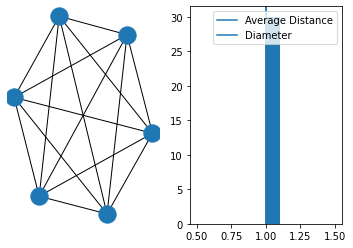

In [12]:
fig, axs = plt.subplots(1,2)
g = nx.complete_graph(n=6)
nx.draw(g, ax = axs[0])

draw_paths(get_shortest_paths(g), axs[1])

ratio = nx.algorithms.distance_measures.diameter(g)/nx.average_shortest_path_length(g)
ratio

2. Describe an example of a graph with at least 6 nodes where the diameter is more than 3
times as large as the average distance. Explain why the diameter is more than 3 times the
average distance.

Here, we begin with a complete graph and iteratively add nodes to a 'tail' until we reach the target ratio of 3:1,

array([1.86246418, 2.48349057, 2.87452471, 3.0945122 , 0.        ])

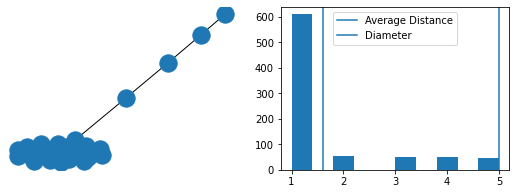

In [13]:
fig, axs = plt.subplots(1,2, figsize = (9,3))

# For plotting
k = 5
ratios = np.zeros(k)
diameters = np.zeros(k)
avgs = np.zeros(k)

g = nx.complete_graph(n=25)

# Cache max node
last_node = max(g.nodes())

for i in range(k):
    g.add_edge(last_node, last_node + 1)
    last_node += 1
    diameters[i] = nx.algorithms.distance_measures.diameter(g)
    avgs[i] = nx.average_shortest_path_length(g)
    ratios[i] = diameters[i]/avgs[i]
    if ratios[i] >=3:
        break

nx.draw(g, ax = axs[0])
draw_paths(get_shortest_paths(g), axs[1])

ratios

For a complete graph of $n=25$ nodes, we need to add 4 nodes to the tail for the ratio of diameter to average path length to be greater than 3 (here, ~3.09). Whenever we add a new node $p$ to the tail, the diameter increases by 1 but the average path length increases at a slower rate, since the vast majority of path lengths is concentrated in the connected component. So as long as the connected component is large relative to the additions to the tail, we can see large diameters. We explore this in more detail in the next sub-problem,

3. Describe how you can construct a graph in which the diameter is more than c times as large as the average distance – for any positive value of c. Briefly explain why or prove that the diameter is more than c times the average distance.


$$c > 3$$ 
$$\frac{Diam(G)}{\mathbb{E}(G)} > 3$$

The diameter here is just $k+1$, as we start with a diameter of 1 when there is a cluster alone, and each appended tail node increases the diameter by 1. To calculate average path length $E(G)$, we decompose the graph $G$ into a fully connected component with $n$ components and a tail with k components, such that the formula becomes, 

$$ \mathbb{E}(G) =  \frac{ \sum_{s,t \in G} d(s,t)}{(n + k)(n + k - 1)} $$

$d(s,t)$ is the shortest path from node $s$ to node $t$ (see `get_shortest_paths()`),

$n$ is the number of nodes in the fully connected "cluster" component in $G$. This includes the gateway node, to which tail nodes are appended to. 

$k$ is the number of nodes in the tail component in $G$. 

To count the total shortest paths $\sum_{s,t \in G} d(s,t)$, we need to consider any node $v_a$ to any another node $v_b$, but also from $v_b$ to $v_a$. We will break this up into two sums, a "cluster to tail" pass and a "tail to cluster" pass. The cluster to tail is straightforward, so we will tackle it first, 

$$ n(n-1) + (n - 1) \sum_{i=1}^{k}(i +1) + \sum_{i=1}^{k}(i)$$

The $n*(n-1)$ counts the 1-paths in the fully connected cluster. The second term counts the paths from each cluster node *except* the gateway node to any node in the tail, and the last term counts the paths from the gateway node to the rest of the tail. We can now move on to the cluster to tail calculation, 

$$ \sum_{p =1}^{k}[ (n - 1)(p + 1) + \sum_{i=1}^{k-p}(i) + \sum_{i=1}^{p}(i - 1) + \frac{p}{2}] $$

This iterates over each node $p$ in the tail, so it is simpler to convey if we assume that $p$ is somewhere in the middle of a tail with $k=8$, say $p = 4$. With this in mind, the $(n-1)(p+1)$ term counts the paths from the cluster to $p$, *excluding the gateway node*, $\sum_{i=1}^{p}(i - 1)$ counts the path lengths from $p$ to preceding nodes in the tail, while the  $\sum_{i=1}^{k-p}(i)$ term counts the path lengths from $p$ to the end of the tail. The last term counts the counts the paths from the gateway node to $p$. 

The following function adds these terms together and computes the average path length, and compares them to their empirical counterparts,

In [14]:
def compute_ratios(n=25, k = 100, dual = True):
    """
    Parameters:
        dual (bool): store empirical values as well. Setting to False will substantially
                     speed up computation. 
        n     (int): nodes in fully connected cluster
        k     (int): nodes in tail
    Returns:
             (dict): arrays of ratios, diameters and average path lengths
    """

    # For plotting
    cols = dual + 1
    diameters = np.zeros((k,cols))
    avgs = np.zeros((k,cols))

    g = nx.complete_graph(n=n)
    # Cache max node
    last_node = max(g.nodes())
    # Initialize
    diameters[0,:] = nx.algorithms.distance_measures.diameter(g)
    avgs[0,:] = nx.average_shortest_path_length(g)

    for i in range(1,k):
        # Add new node to tail
        g.add_edge(last_node, last_node + 1)
        last_node += 1

        # Tally empirical values, if needed
        if dual:
            diameters[i, 1] = nx.algorithms.distance_measures.diameter(g)
            avgs[i, 1] = nx.average_shortest_path_length(g)

        # Count total min path lengths
        p = np.arange(1,i + 1)
        paths_from_k =  sum((n - 1)*(p + 1) + p/2 + (p**2)/2 + ((i - p)*(1 + i - p))/2)
        paths_to_k =  n*(n-1) + (n - 1)*sum(p + 1) + sum(p)

        # Compute theoretical avg
        avg_path = (paths_from_k + paths_to_k) / ((n + i)*(n + i - 1))
        avgs[i,0] = avg_path

        # Theoretical diameter
        diameter = i + 1
        diameters[i,0] = diameter
        
    ratios = diameters/avgs

    return {"ratios":ratios, "avgs":avgs, "diameters":diameters}

compute_ratios(k=10)["avgs"]

array([[1.        , 1.        ],
       [1.07384615, 1.07384615],
       [1.20797721, 1.20797721],
       [1.39153439, 1.39153439],
       [1.61576355, 1.61576355],
       [1.87356322, 1.87356322],
       [2.15913978, 2.15913978],
       [2.46774194, 2.46774194],
       [2.79545455, 2.79545455],
       [3.13903743, 3.13903743]])

In [15]:
def get_ratio(n,k):
    p = np.arange(1,k+1)

    paths_from_k =  sum((n - 1)*(p + 1) + p/2 + (p**2)/2 + ((k - p)*(1 + k - p))/2)
    paths_to_k =  n*(n-1) + (n - 1)*sum(p + 1) + sum(p)

    avg_path = (paths_from_k + paths_to_k) / ((n + k)*(n + k - 1))  
    diameter = k + 1

    return diameter/avg_path

get_ratio(25, 10)

3.1466346153846154

The empirical and theoretical averages match exactly, which is a striking result. Empirically computing averages is an $O((n+k)^2)$ operation, while computing it according to the theoretical result is $O(1)$! This makes plotting over a large number of $n$ and $k$ straightforward (note: computing empirical means can be toggled off by setting `dual = False`), after which we can just pick a combination of $n$ and $k$ for the desired ratio $c$,

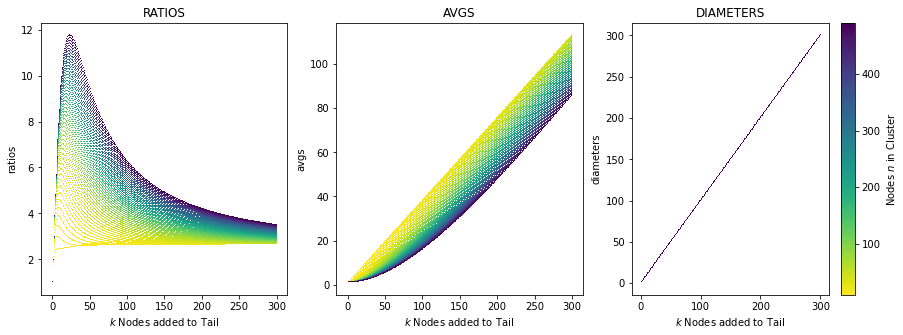

In [16]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
n = np.arange(10,500,10)
cmap = cm.get_cmap('viridis_r' )

for i in range(len(n)):
    for ax,d in zip(axs.flatten(), compute_ratios(n = n[i], k = 300, dual = False).items()):
        ax.plot(
            d[1], 
            ',',
            label = f"$n = {i}$",
            color = cmap(np.cumsum(n)[i]/sum(n)),
            
            )
        ax.set_title(d[0].upper())
        ax.set_xlabel('$k$ Nodes added to Tail' )
        ax.set_ylabel(d[0])

sm = plt.cm.ScalarMappable(cmap=cmap, norm = plt.Normalize(vmin = n.min(), vmax = n.max()))
cb = plt.colorbar(sm)
cb.set_label("Nodes $n$ in Cluster")

plt.show()

The interesting thing here is that high ratios prove difficult to find, as for a fixed $n$ the ratio has a global maxima for a relatively small $k$. So if we desire a very high $c$, we will need a large number of nodes $n$ to reach it.

# Problem 4: Hopfield Network

In [17]:
def generate_bitmap(text, size):
    """ Return a numpified image of text, with values in [-1,1]"""
    pil_font = ImageFont.truetype(
        "/Library/Fonts/Arial.ttf",
         size = int(2*size//len(text)))

    text_width, text_height = pil_font.getsize(text)
    
    canvas = Image.new('RGB', [size, size], (255, 255, 255))
    # draw the text onto the canvas
    draw = ImageDraw.Draw(canvas)
    offset = ((size - text_width)//2,
              (size - text_height)//2)
    white = "#000000"
    draw.text(offset, text, font=pil_font, fill=white)

    # Clip Values
    img = (255 - np.asarray(canvas)) / 255.0

    # Constrain values to {-1, 1} selon McKay
    img = np.where(img > 0, -1, 1)
    
    # Return just 1 color channel
    return img[..., 1]

class Hopfield:
    def __init__(self, shape, rule = "Hebbian") -> None:
        """
        Initialise a hopfield network
        Params:
            shape (arr[2]): shape of memory in [w,h]
        """
        # Width
        self.w = shape[0]
        # Height
        self.h = shape[1]
        self.rule = rule

        self.truths = []

        # step*step image -> N = 2step
        self.N = self.w * self.h
        if rule == "Hebbian":
            self.capacity = 0.138*self.N

        # Fully connected, W_ij represents connections from 
        # Node i to Node j
        self.W = np.zeros((self.N,self.N))

        # Current State
        self.s = np.zeros((self.N,1))

    # Activation i = state.w[i]
    def activate(self, type = 'async'):

        if type == 'async':
            # Async: pick a random node
            i = np.random.randint(0,self.N)
            a = self.W[i,:]@self.s

            # if dot prod < 01 
            if a < 0:
                # Activate to -1 
                self.s[i] = -1
            else:
                # Activate to +1
                self.s[i] = 1
        elif type == 'sync':
            self.s = np.sign(self.W@self.s)

    def update(self,n_updates = 1000, step = 10, display = True, type = 'async'):
        """Update one node at a time (asyn) or all at once"""

        # Plot every few frames
        if display:
            frames = n_updates//step
            fig, axs = plt.subplots(
                2, 
                frames//2,
                tight_layout = True, 
                figsize = (10,3)
                )
            
            axes = axs.flatten()

            t = 0
            for i in range(n_updates):
                self.activate(type)
                if i%step == 0:
                    self.show(ax = axes[t], idx = i+1)
                    t += 1
        else:
            # Collect data on deviation from true
            loss = []
            energy = []
            
            for i in range(n_updates):
                self.activate()
                try:
                    loss.append(self.measure_loss(self.truths, self.s))
                    energy.append(self.measure_energy())
                except:
                    pass

            return loss, energy

    def measure_loss(self, truth, curr_state):
        """Sum of abs deviations from grouth truth"""
        return np.sum(np.abs(truth - curr_state), axis = 1)
    
    def measure_energy(self):
        return -0.5 * np.sum(np.multiply(np.outer(self.s,self.s), self.W))

    def store(self, mem):
        """Store a memory mem in Weights"""

        # Flatten pixel grid to array
        mem = mem.flatten()
        assert len(mem) == self.N
        self.truths.append(mem)

        # Learn Weights with Hebbian Rule
        # :: fully connected adjacency matrix 
        # Add on top of last memory
        if self.rule == "Hebbian":
            self.W  += np.outer(mem,mem)/len(mem)
            
        elif self.rule == "Storkey":
            hebbian = np.outer(mem,mem)
            net_in = self.W.dot(mem)

            pre_syn = np.outer(mem, net_in)
            post_syn = pre_syn.T

            self.W += (1./len(mem))*(hebbian - pre_syn - post_syn)

        # as j != i in update
        np.fill_diagonal(self.W, 0)

    def show(self, ax = False, idx = 0):
        # Reshape representation
        representation = self.s.reshape(self.w, self.h)
        if ax:
            ax.imshow(representation, cmap = 'Greys')
            ax.set_title(f'$s = {idx}$')
            ax.axis('off')
        else:
            plt.imshow(representation, cmap = 'Greys')

    def perturb_input(self, letter:np.array, amount:float = 0.4):
        """Add color-in noise to letter and store in state """
        size = letter.size
        n_pixels = round(size * amount)
        
        perturbed_letter = np.copy(letter)

        pixels = np.random.randint(0, size - 1, size = n_pixels)
        pixels = np.unravel_index(pixels, letter.shape)
        perturbed_letter[pixels] = 1

        self.s = perturbed_letter.flatten()
        
        return letter

def plot_states(data, e, net, labels = ["A","B","C"], ):
    """" Plot Pattern (in labels) Recall and Energy change over state updates."""
    data = np.array(data)

    fig, axs = plt.subplots(
        2,1, 
        figsize = (5,3), 
        gridspec_kw= {'height_ratios': [3,1]}, 
        tight_layout = True,
        sharex = True )

    # Pattern Recall
    axs[0].axhline(0, linestyle = '--', label = "Ground Truth", color = 'grey')
    for i,l in zip(range(len(labels)), labels):     
        axs[0].plot(data[:,i], label = l)
    
    axs[0].set_xlabel("$i$ state updates")
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Hopfield with {net.rule} Rule, {len(net.truths)} patterns")
    axs[0].legend()

    axs[1].plot(e)
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Energy (J)")

    plt.show()

A = np.array([
    [-1, 1, 1, -1],
    [1, -1, -1, 1],
    [1, 1, 1, 1],
    [1, -1, -1, 1],
    [1, -1, -1, 1]
])
B = np.array([
    [1, 1, 1, -1],
    [1, -1, -1, 1],
    [1, 1, 1, -1],
    [1, -1, -1, 1],
    [1, 1, 1, -1]
])
C = np.array([
    [-1, 1, 1, -1],
    [1, -1, -1, 1],
    [1, -1, -1, -1],
    [1, -1, -1, 1],
    [-1, 1, 1, -1]
])

Below, we initialize a Hebbian rule Hopfield network and store two patterns `:)` and `<3`. We then perturb the latter by adding noise and see if the network can recall the pattern. Recall is performed using `Hopfield.update()` and works by iteratively updating a state vector (`Hopfield.s`) according to activations over each node (ie, pixels).

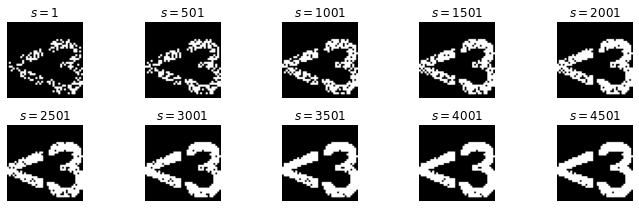

In [18]:
y = generate_bitmap(":)", 40)
h = generate_bitmap("<3", 40)

hope = Hopfield(y.shape)
hope.store(y)
hope.store(h)

hope.perturb_input(h, amount=0.9)
hope.update(n_updates=5000, step = 500, type = 'async', display  = True)

The Hopfield network manages to mend a broken heart. This process happens faster if we use synchronous updates over the state of the network, as seen below,

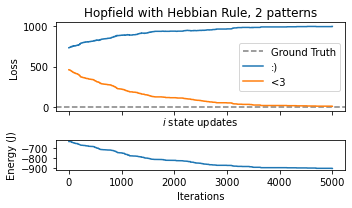

In [19]:
hope.perturb_input(h, amount=0.8)

data, e = hope.update(n_updates=5000, step = 100, type = 'sync', display  = False)
plot_states(data, e, hope, labels = [":)", "<3"])

'Loss' measures the sum of absolute deviations between the state of the network at iteration $i$ and the actual pattern. As a result, if any line touches 0 the network has achieved 'Ground Truth' or perfect recall of the stored pattern. Here, this can be seen with the `<3` pattern. As the state converges with this pattern, it deviates increasingly away from the alternative pattern `:)` while also minimizing the energy of the system. In general, the recall task is an iterative task of minimizing the system's energy component, which *can* approach local as well as global (Ground Truth) minima, as we will see below,

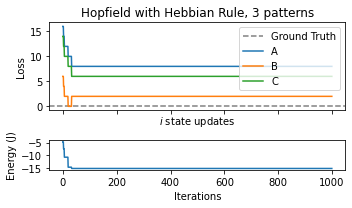

2.7600000000000002

In [20]:
hebbian = Hopfield(A.shape, rule = "Hebbian")
[hebbian.store(i) for i in [A,B,C]]

hebbian.perturb_input(B, amount=0.5)
data, e = hebbian.update(n_updates=1000, step = 10, type = 'async', display=False)

plot_states(data, e, hebbian, labels = ["A", "B", "C"])
hebbian.capacity

The capacity of this Hebbian network is 2.76 patterns, and we are attempting to store patterns  "A","B" and "C". The orange line corresponding to pattern B gets the closest to the ground truth or perfect accuracy, but never reaches 0: it has reached a local minimum and makes no further progress:

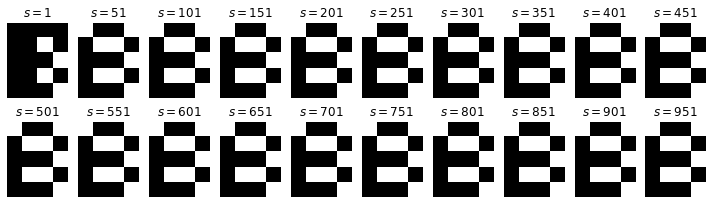

In [21]:
hebbian.perturb_input(B, 0.9)
hebbian.update(n_updates=1000, step = 50, type = "async")

While this is very close to the original `B` pattern, a tile in the top-left corner is missing, leading to a hybridized image of `A` and `B`. When applied with the Storkey learning rule, the Hebbian network can store a third pattern,

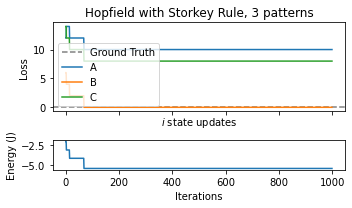

In [22]:
strokey = Hopfield(A.shape, rule = "Storkey")
[strokey.store(i) for i in [A,B,C]]

strokey.perturb_input(B, 0.9)
data, e = strokey.update(n_updates=1000, step = 10, type = "async", display = False)

plot_states(data, e, strokey, labels = ["A", "B", "C"])

Unlike the Hebbian rule, the Storkey rule reaches the global minimum and reproduces the `B` entirely, implying that it makes better 'sense' of the pattern than the Hebbian rule.

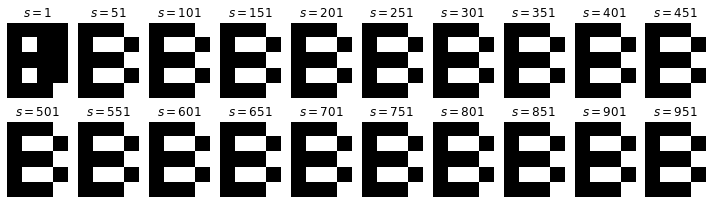

In [23]:
strokey.perturb_input(B, 0.9)
strokey.update(n_updates=1000, step = 50, type = "async")